<img src="https://www.escoladnc.com.br/wp-content/uploads/2022/06/dnc_formacao_dados_logo_principal_preto-1.svg" alt="drawing" width="300"/>

# Análise Exploratória do MovieLens

Este notebook explora as diferentes características de um dataset de recomendação. Em particular, será utilizada uma amostra do [MovieLens](https://grouplens.org/datasets/movielens/), um dataset com avaliações de usuários para filmes coletados através de uma interface web.

**Nota**: este dataset possui diversas versões (MovieLens 100k, 1M, 10M, 25M) em referência à quantidade de avaliações presentes no arquivo de _ratings_. Caso queira saber mais sobre a história do dataset, confira o artigo [The MovieLens Datasets: History and Context (2015)](http://files.grouplens.org/papers/harper-tiis2015.pdf).

In [ ]:
import os
import pandas as pd
from google.colab import files
import matplotlib.pyplot as plt
import matplotlib
from cycler import cycler

matplotlib.rcParams['axes.prop_cycle'] = cycler(color=['#007efd', '#FFC000', '#303030'])

# Carregando o dataset

O dataset composto pelos seguintes arquivos:

- `ratings.parquet`: avaliações de usuários para filmes em um determinado timestamp
- `movies.parquet`: metadados dos filmes
- `users.parquet`: metadados dos usuários

## Arquivo de avaliações

Upload file `ratings.parquet`

In [ ]:
%%time
_ = files.upload() # approx: 1min8s

Saving ratings.parquet to ratings.parquet
CPU times: user 1.09 s, sys: 226 ms, total: 1.32 s
Wall time: 1min 29s


In [ ]:
df_ratings = pd.read_parquet('ratings.parquet')
df_ratings.tail()

,user_id,item_id,rating,timestamp
1000204,6040,1091,1,956716541
1000205,6040,1094,5,956704887
1000206,6040,562,5,956704746
1000207,6040,1096,4,956715648
1000208,6040,1097,4,956715569


## Arquivo de metadados dos usuários

Upload file users.parquet

In [ ]:
_ = files.upload()

Saving users.parquet to users.parquet


In [ ]:
df_users = pd.read_parquet('users.parquet')
df_users.tail()

,user_id,gender,age,occupation,zip_code
6035,6036,F,25,15,32603
6036,6037,F,45,1,76006
6037,6038,F,56,1,14706
6038,6039,F,45,0,01060
6039,6040,M,25,6,11106


## Arquivo de metadados dos itens

Upload file `movies.parquet`

In [ ]:
%%time
_ = files.upload() # approx: 10s

Saving movies.parquet to movies.parquet
CPU times: user 185 ms, sys: 18 ms, total: 203 ms
Wall time: 16.4 s


In [ ]:
df_items = pd.read_parquet('movies.parquet')
df_items.tail()

,item_id,title,genres
3878,3948,Meet the Parents (2000),Comedy
3879,3949,Requiem for a Dream (2000),Drama
3880,3950,Tigerland (2000),Drama
3881,3951,Two Family House (2000),Drama
3882,3952,"Contender, The (2000)",Drama|Thriller


# Pré-processamento

A partir do carregamento dos arquivos, faremos as seguintes transformações:

- extrair a data do campo `timestamp`
- extrair o ano de lançamento do filme a partir do seu título
- converter a _string_ concatenada de gêneros em listas de gêneros

In [ ]:
# Essa função timestamp serve justamente para converter o campo para data.
from datetime import datetime
def convert_timestamp_to_date(timestamp:int):
    return datetime.fromtimestamp(timestamp).date()

df_ratings['date'] = df_ratings['timestamp'].apply(convert_timestamp_to_date)
df_ratings.tail()

,user_id,item_id,rating,timestamp,date
1000204,6040,1091,1,956716541,2000-04-26
1000205,6040,1094,5,956704887,2000-04-25
1000206,6040,562,5,956704746,2000-04-25
1000207,6040,1096,4,956715648,2000-04-26
1000208,6040,1097,4,956715569,2000-04-26


In [ ]:
df_items.tail()

,item_id,title,genres
3878,3948,Meet the Parents (2000),Comedy
3879,3949,Requiem for a Dream (2000),Drama
3880,3950,Tigerland (2000),Drama
3881,3951,Two Family House (2000),Drama
3882,3952,"Contender, The (2000)",Drama|Thriller


In [ ]:
import re
def extract_year_from_title(title:str, regex='(\d{4})'):
    match = re.search(regex, title)
    return None if match is None else match.group()

def convert_genres_to_list(genres:str, separator='|'):
    return genres.split(separator)

df_items['year'] = df_items['title'].apply(extract_year_from_title)
df_items['genres_list'] = df_items['genres'].apply(convert_genres_to_list)
df_items.tail()

,item_id,title,genres,year,genres_list
3878,3948,Meet the Parents (2000),Comedy,2000,[Comedy]
3879,3949,Requiem for a Dream (2000),Drama,2000,[Drama]
3880,3950,Tigerland (2000),Drama,2000,[Drama]
3881,3951,Two Family House (2000),Drama,2000,[Drama]
3882,3952,"Contender, The (2000)",Drama|Thriller,2000,"[Drama, Thriller]"


_____________________

## Distribuição de Dados Categóricos

A função `plot_category_count` abaixo auxilia na visualização de contagem dos dados categóricos. Como o campo `rating` é um inteiro no intervalo $[1, 5]$, podemos considerar este campo também uma categoria.

In [ ]:
def plot_category_count(category:pd.Series, figsize=(16, 8)):
    """Categorias como index"""
    fig, ax = plt.subplots(figsize=figsize)
    ax.barh(category.index, category.values)
    ax.grid(True, linestyle='--')
    ax.set_xlabel('Count')
    return fig, ax

Visualizando a distribuição de gêneros

(<Figure size 1600x800 with 1 Axes>, <Axes: xlabel='Count'>)

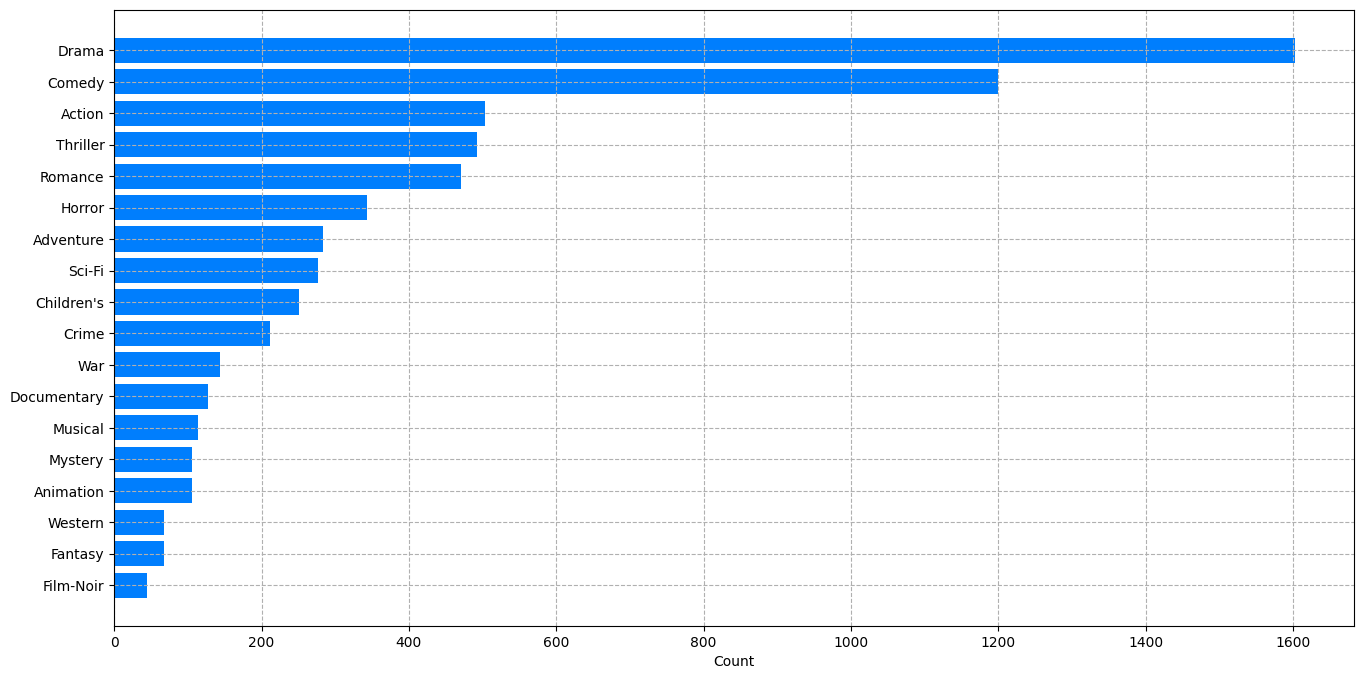

In [ ]:
genres = (
    df_items
    .explode('genres_list')
    .groupby('genres_list')
    .count()['item_id']
    .sort_values(ascending=True) # True ordena de forma crescente e False ordena de forma decrescente.
)
genres
plot_category_count(genres)

Visualizando a distribuição de _ratings_

(<Figure size 1600x800 with 1 Axes>, <Axes: xlabel='Count'>)

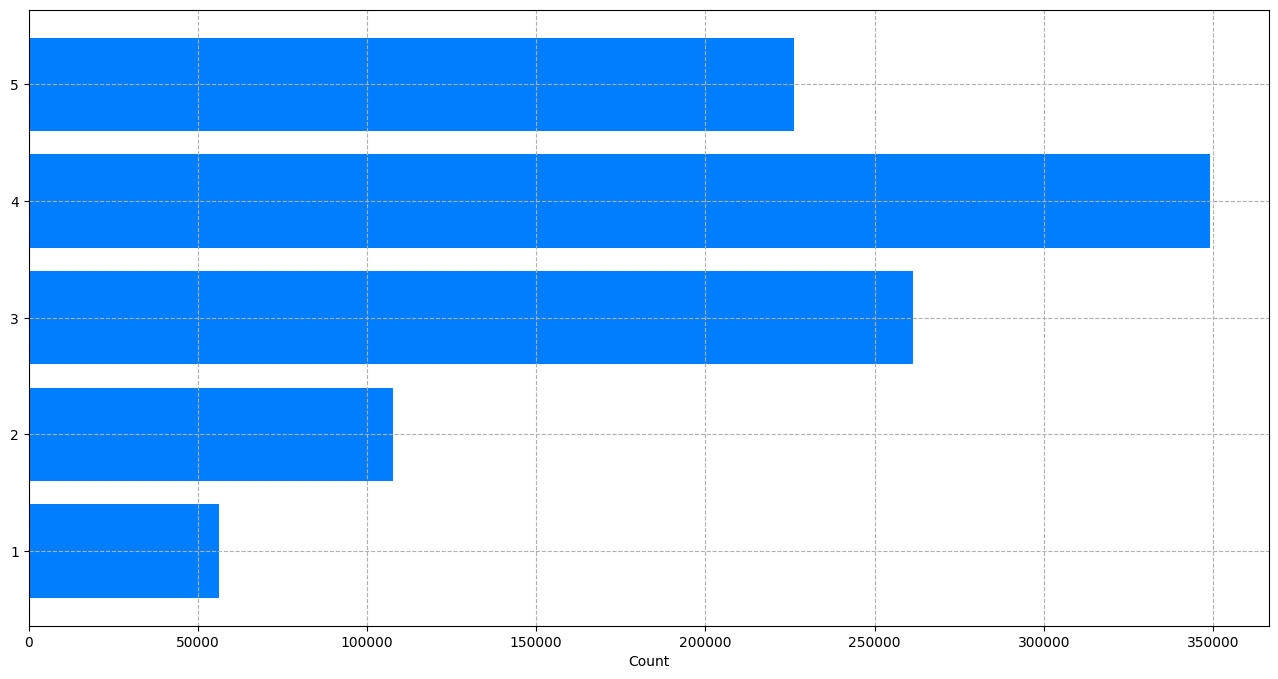

In [ ]:
ratings = df_ratings.groupby('rating').count()['user_id']
plot_category_count(ratings)

## Evolução Temporal das Avaliações

A função `plot_daily_ratings` nos auxilia a visualizar quantas avaliações foram dadas diariamente e como é evolução dessas avaliações ao longo do tempo.

(<Figure size 1600x800 with 1 Axes>,
 <Axes: xlabel='Date', ylabel='Number of ratings'>)

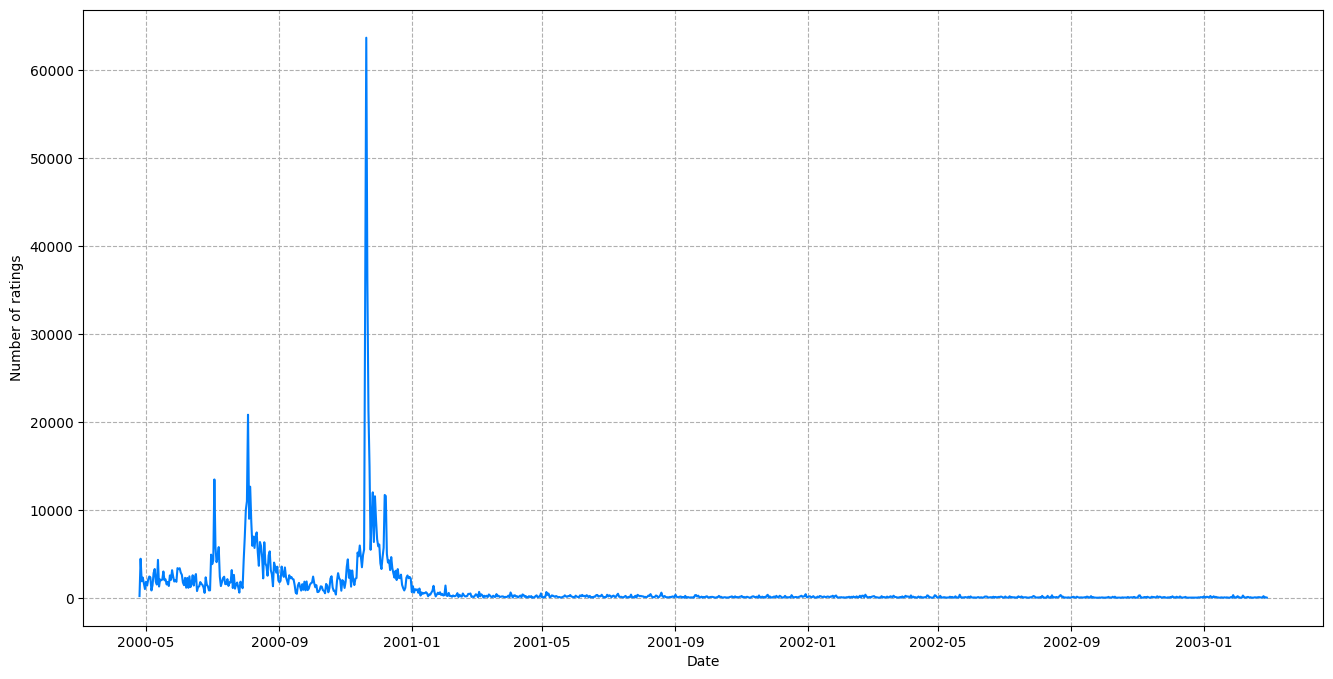

In [ ]:
def plot_daily_ratings(daily_ratings:pd.Series, figsize=(16,8)):
    fig, ax = plt.subplots(figsize=figsize)
    ax.plot(daily_ratings)
    ax.set_xlabel('Date')
    ax.set_ylabel('Number of ratings')
    ax.grid(True, linestyle='--')
    return fig, ax

daily_ratings = df_ratings.groupby('date').count()['user_id'].sort_index(ascending=False)
plot_daily_ratings(daily_ratings)

________________

# Análise da Esparsidade

Um dos fatores que mais impactam os sistemas de recomendação (sobretudo os baseados em filtragem colaborativa) é a esparsidade do cenário onde eles são aplicados. De uma forma resumida, a esparsidade pode ser entendida como uma medida da falta de informação. Neste notebook, analisamos a esparsidade de 2 formas diferentes: a esparsidade geral e a esparsidade específica para usuários/itens.



## Esparsidade Geral (_Overall Sparsity_)

A _overall sparsity_ (OS) pode ser calculada como:

$$OS = 1 - \frac{\#ratings}{\#users \times \#items}$$

onde $\#ratings$ é o número de avaliações dadas, $\#users$ é o número de usuários no sistema e $\#items$ é o número de itens no catálogo. **Quanto menos avaliações tivermos dos usuários, maior será a esparsidade**.

Exemplo:

- Poucas avaliações preenchidas: $OS \rightarrow 100\%$ (alta esparsidade)
- Muitas avaliações preenchidas: $OS \rightarrow 0\%$ (baixa esparsidade)

In [ ]:
n_users = df_users['user_id'].nunique()
n_items = df_items['item_id'].nunique()
n_ratings = df_ratings[['user_id', 'item_id']].drop_duplicates().shape[0]

print (f'#Usuários: {n_users}')
print (f'#Itens: {n_items}')
print (f'#Avaliações: {n_ratings}')

#Usuários: 6040
#Itens: 3883
#Avaliações: 1000209


In [ ]:
overall_sparsity = 1 - n_ratings / (n_users * n_items)
print ('Overall Sparsity: {:.02f} %'.format(100*overall_sparsity))

Overall Sparsity: 95.74 %


A matriz de preferências pode ser calculada da seguinte forma:

In [ ]:
df_ratings.tail()

,user_id,item_id,rating,timestamp,date
1000204,6040,1091,1,956716541,2000-04-26
1000205,6040,1094,5,956704887,2000-04-25
1000206,6040,562,5,956704746,2000-04-25
1000207,6040,1096,4,956715648,2000-04-26
1000208,6040,1097,4,956715569,2000-04-26


In [ ]:
df_preferences = df_ratings.pivot(
    index='user_id', 
    columns='item_id',
    values='rating'
)
df_preferences = df_preferences.fillna(0)
df_preferences

item_id,1,2,3,4,5,6,7,8,9,10,...,3943,3944,3945,3946,3947,3948,3949,3950,3951,3952
user_id,,,,,,,,,,,,,,,,,,,,,
1,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6036,0.0,0.0,0.0,2.0,0.0,3.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6037,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6038,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


A função `plot_preference_matrix` nos auxilia a visualizar a esparsidade da matriz de preferências.

(<Figure size 1600x800 with 1 Axes>,
 <Axes: title={'center': 'Preference Matrix (Overall Sparsity 95.74 %)'}, xlabel='Users', ylabel='Items'>)

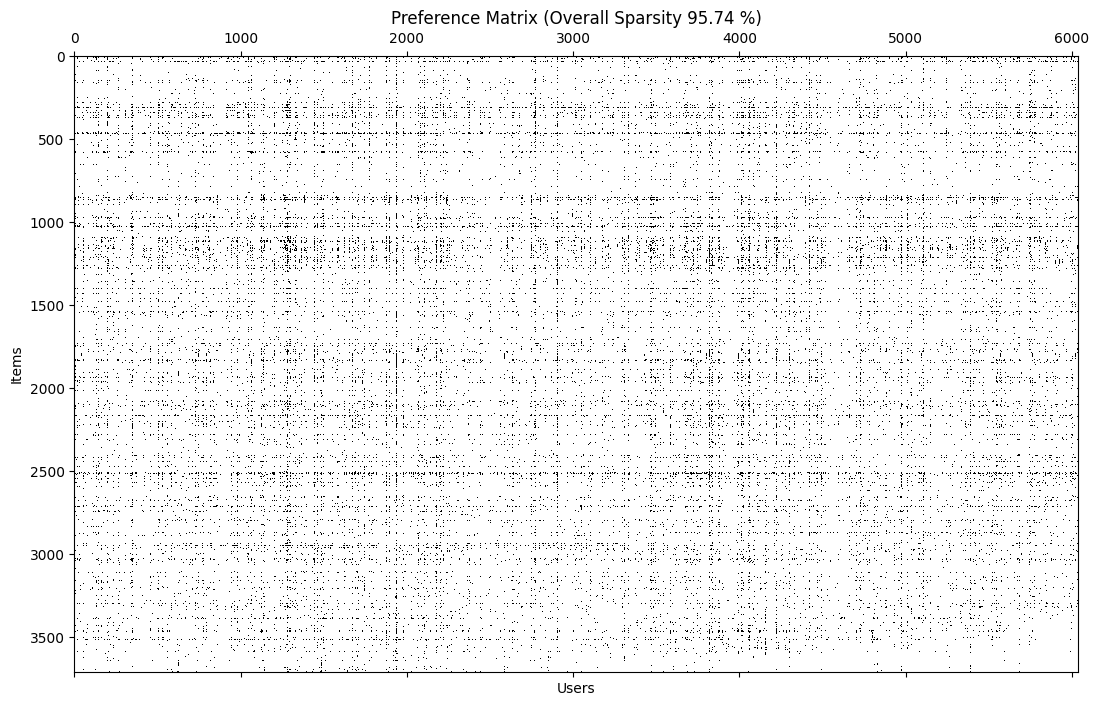

In [ ]:
def plot_preference_matrix(df_preferences:pd.DataFrame, sparsity:float, figsize=(16,8)):
    fig, ax = plt.subplots(figsize=figsize)
    ax.spy(df_preferences.values.T) # Serve para plotar uma matriz onde se o ponto dessa matriz for maior que 0 ele coloca um ponto preto caso contrario ele coloca um ponto branco.
    ax.set_ylabel('Items')
    ax.set_xlabel('Users')
    ax.set_title('Preference Matrix (Overall Sparsity {:.02f} %)'.format(100*sparsity))

    return fig, ax

plot_preference_matrix(df_preferences, overall_sparsity

## Esparsidade Específica de Usuário/Item

De forma análoga à _overall sparsity_, também podemos calcular a _User Specific Sparsity_ (USS) e a _Item Specific Sparsity_ (ISS) da seguinte forma:

$$USS(\mathbf{u}) = 1 - \frac{\#ratings_\mathbf{u}}{\#items}$$

$$ISS(\mathbf{i}) = 1 - \frac{\#ratings_\mathbf{i}}{\#users}$$

Onde $\#ratings_\mathbf{u}$ é a quantidade de avaliações do usuário $\mathbf{u}$ e $\#ratings_\mathbf{i}$ é a quantidade de avaliações do item $\mathbf{i}$.

Exemplos:

- Usuário com poucas avaliações: $USS(\mathbf{u}) \rightarrow 100\%$
- Itens com muitas avaliações: $ISS(\mathbf{i}) \rightarrow 0\%$

In [ ]:
users_ratings = df_ratings.groupby('user_id').count()['item_id']
users_sparsity = 1 - users_ratings / n_items
users_sparsity

user_id
1       0.986351
2       0.966778
3       0.986866
4       0.994592
5       0.949008
          ...   
6036    0.771311
6037    0.947978
6038    0.994849
6039    0.968323
6040    0.912181
Name: item_id, Length: 6040, dtype: float64

In [ ]:
items_ratings = df_ratings.groupby('item_id').count()['user_id']
items_sparsity = 1 - items_ratings / n_users
items_sparsity

item_id
1       0.656126
2       0.883940
3       0.920861
4       0.971854
5       0.950993
          ...   
3948    0.857285
3949    0.949669
3950    0.991060
3951    0.993377
3952    0.935762
Name: user_id, Length: 3706, dtype: float64

Em geral, os itens de menor esparsidade são os itens ditos **_Blockbuster_** (ou seja, os que mais são consumidos). Podemos verificar isso analisando os IDs dos **itens de menor esparsidade:**

In [ ]:
item_ids = items_sparsity[:3].index
df_items[df_items['item_id'].isin(item_ids)]

,item_id,title,genres,year,genres_list
0,1,Toy Story (1995),Animation|Children's|Comedy,1995,"[Animation, Children's, Comedy]"
1,2,Jumanji (1995),Adventure|Children's|Fantasy,1995,"[Adventure, Children's, Fantasy]"
2,3,Grumpier Old Men (1995),Comedy|Romance,1995,"[Comedy, Romance]"


Por fim, como cada usuário ou item possui a sua própria esparsidade, podemos visualizar a **distribuição dessas esparsidades** específicas através da função `plot_sparsity_distribution`.

In [ ]:
def plot_sparsity_distribution(sparsity, ylabel, figsize=(16,8), bins=100):
    fig, ax = plt.subplots(figsize=figsize)
    ax.grid(True, linestyle='--')
    ax.hist(100*sparsity, bins=bins)
    ax.set_ylabel(ylabel)
    ax.set_xlabel('Sparsity')
    ax.set_xlim(right=100.0)
    xticks = matplotlib.ticker.FormatStrFormatter('%.0f%%')
    ax.xaxis.set_major_formatter(xticks)
    return fig, ax

(<Figure size 1600x800 with 1 Axes>, <Axes: xlabel='Sparsity', ylabel='Users'>)

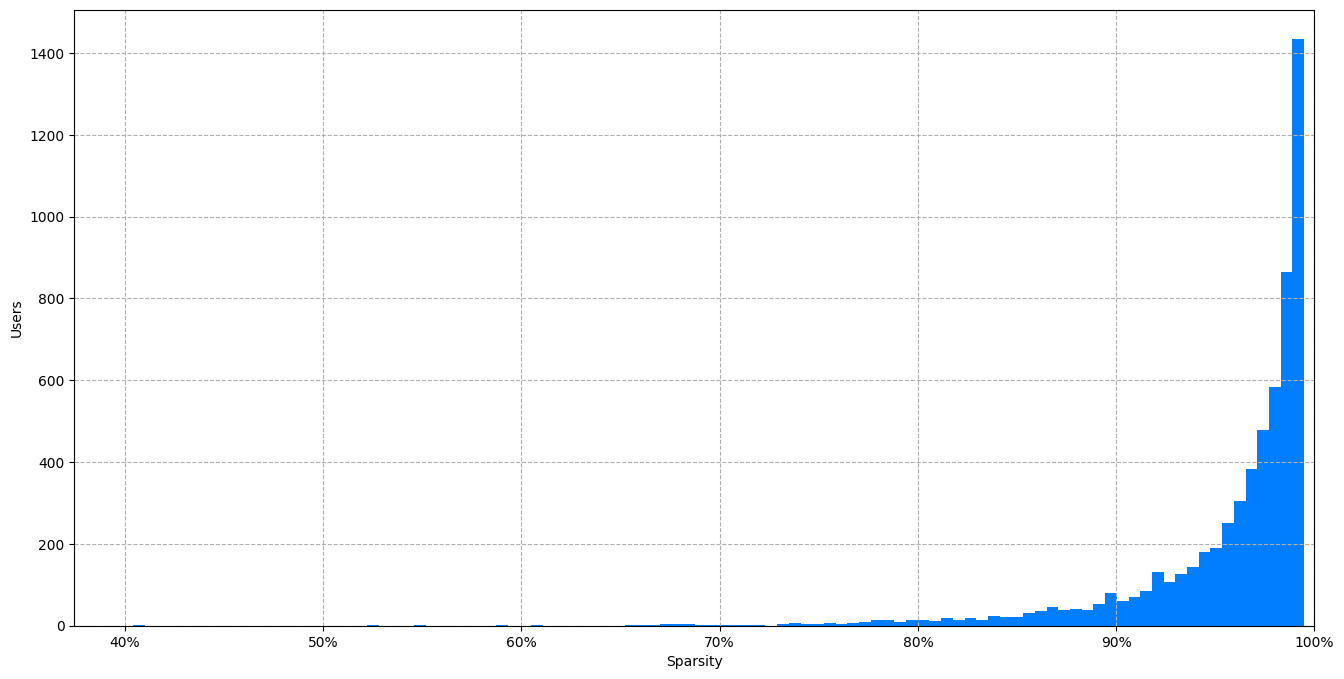

In [ ]:
plot_sparsity_distribution(users_sparsity, ylabel='Users')

(<Figure size 1600x800 with 1 Axes>, <Axes: xlabel='Sparsity', ylabel='Items'>)

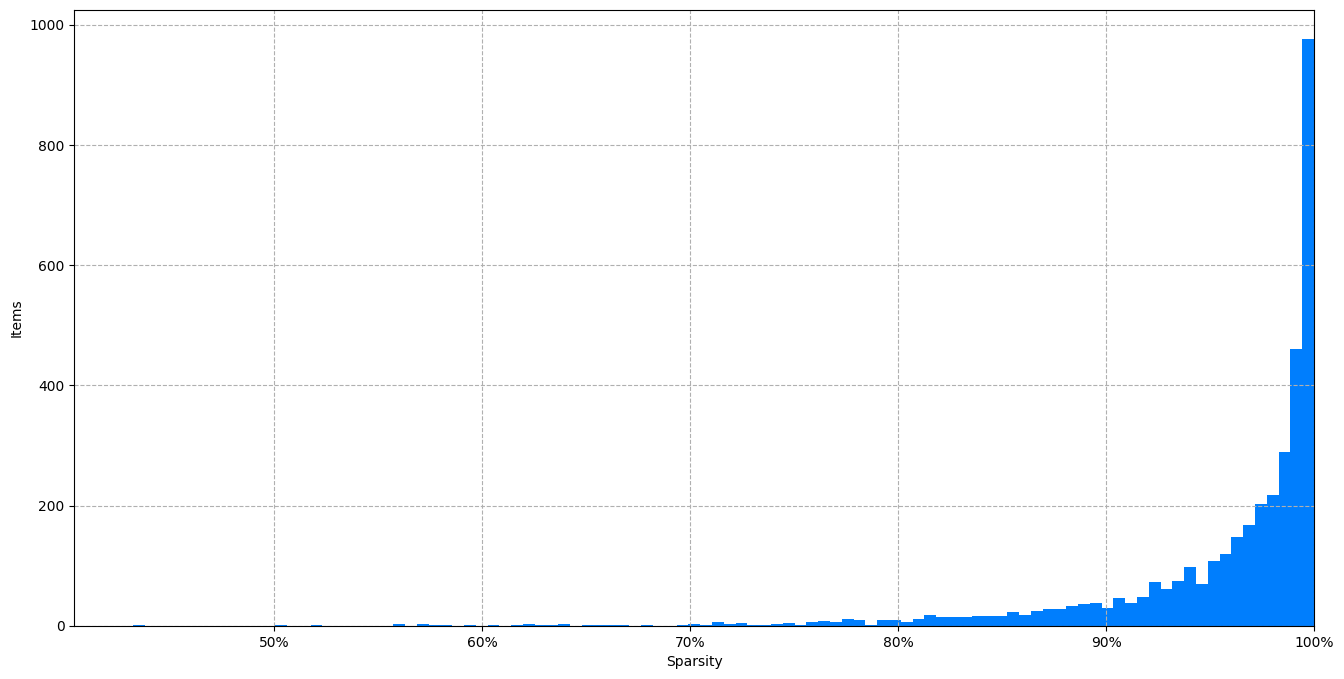

In [ ]:
plot_sparsity_distribution(items_sparsity, ylabel='Items')